# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 1D problem

### Manufactured solution


We use $u = x^3$ for $x\in [0,4]$ to manufacture the right hand side to be $f=sin(x)$

### Importing packages

In [121]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [122]:
np.random.seed(123)
X_tr_pde = np.random.uniform(0,3,1000).reshape(1000,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

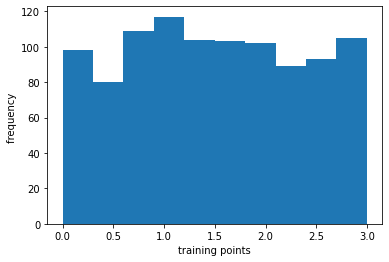

In [123]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

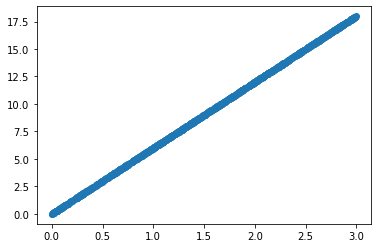

In [124]:
Y_tr_pde = 6*X_tr_pde
plt.scatter(X_tr_pde,Y_tr_pde)

In [125]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((X_tr_pde.size,1))],axis=1)
Y_tr_pde.shape

(1000, 2)

In [126]:
X_tr_Dr_bc_left = np.zeros(100).reshape(100,1)
X_tr_Dr_bc_right = 3*np.ones(100).reshape(100,1)
X_bc = np.concatenate([X_tr_Dr_bc_left,X_tr_Dr_bc_right],axis=0)

Y_tr_Dr_bc_left = X_tr_Dr_bc_left**3
Y_tr_Dr_bc_right = X_tr_Dr_bc_right**3
Y_tr_bc = np.concatenate([Y_tr_Dr_bc_left,Y_tr_Dr_bc_right],axis=0)
Y_tr_bc = np.concatenate([Y_tr_bc,np.ones((200,1))],axis=1)
Y_tr_bc

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,

In [127]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_bc), axis=0)

In [128]:
Y_tr

array([[12.53644534,  0.        ],
       [ 5.15050803,  0.        ],
       [ 4.08332616,  0.        ],
       ...,
       [27.        ,  1.        ],
       [27.        ,  1.        ],
       [27.        ,  1.        ]])

## Training the model

In [129]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(30, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(1,
                                         name="dense_3")

    def findGrad(self,func,argm):
        return keras.layers.Lambda(lambda x: K.gradients(x[0],x[1])) ([func,argm])
    
    def call(self, inputs):
        layer_1 = self.dense_1(inputs)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        
        grad_layer = self.findGrad(layer_3, inputs)
        laplace_layer = self.findGrad(grad_layer, inputs)
        
        return layer_3, laplace_layer



In [130]:
custom_model = CustomModel()

In [131]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

In [132]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-3))

In [136]:
custom_model.fit(x=X_tr, y=Y_tr,epochs=40)

Epoch 1/40
38/38 [==============================] - 0s 4ms/step - loss: 5.4814 - output_1_loss: 0.1896 - output_2_1_loss: 5.2918
Epoch 2/40
38/38 [==============================] - 0s 4ms/step - loss: 4.2636 - output_1_loss: 0.3176 - output_2_1_loss: 3.9460
Epoch 3/40
38/38 [==============================] - 0s 4ms/step - loss: 4.7175 - output_1_loss: 0.3755 - output_2_1_loss: 4.3420
Epoch 4/40
38/38 [==============================] - 0s 4ms/step - loss: 4.5042 - output_1_loss: 0.2686 - output_2_1_loss: 4.2356
Epoch 5/40
38/38 [==============================] - 0s 4ms/step - loss: 4.8906 - output_1_loss: 0.3094 - output_2_1_loss: 4.5812
Epoch 6/40
38/38 [==============================] - 0s 5ms/step - loss: 3.8241 - output_1_loss: 0.2482 - output_2_1_loss: 3.5759
Epoch 7/40
38/38 [==============================] - 0s 6ms/step - loss: 4.7480 - output_1_loss: 0.5122 - output_2_1_loss: 4.2358
Epoch 8/40
38/38 [==============================] - 0s 4ms/step - loss: 3.8666 - output_1_loss: 0

In [139]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-5))
custom_model.fit(x=X_tr, y=Y_tr,epochs=40)

Epoch 1/40
38/38 [==============================] - 0s 5ms/step - loss: 0.3258 - output_1_loss: 1.4336e-04 - output_2_1_loss: 0.3256
Epoch 2/40
38/38 [==============================] - 0s 6ms/step - loss: 0.3255 - output_1_loss: 1.3051e-04 - output_2_1_loss: 0.3254
Epoch 3/40
38/38 [==============================] - 0s 4ms/step - loss: 0.3231 - output_1_loss: 1.9144e-04 - output_2_1_loss: 0.3229
Epoch 4/40
38/38 [==============================] - 0s 4ms/step - loss: 0.3246 - output_1_loss: 2.6261e-04 - output_2_1_loss: 0.3243
Epoch 5/40
38/38 [==============================] - 0s 4ms/step - loss: 0.3250 - output_1_loss: 1.2593e-04 - output_2_1_loss: 0.3249
Epoch 6/40
38/38 [==============================] - 0s 5ms/step - loss: 0.3243 - output_1_loss: 1.2382e-04 - output_2_1_loss: 0.3242
Epoch 7/40
38/38 [==============================] - 0s 5ms/step - loss: 0.3230 - output_1_loss: 2.8657e-04 - output_2_1_loss: 0.3227
Epoch 8/40
38/38 [==============================] - 0s 5ms/step - los

In [143]:
X_test_st = np.random.uniform(0,2,500).reshape(500,1)

In [144]:
Y_test = custom_model.predict(X_test_st)

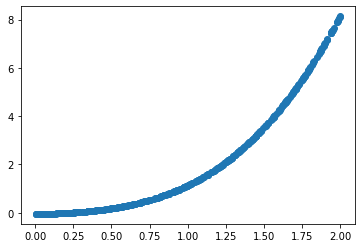

In [145]:
plt.scatter(X_test_st, Y_test[0][:,0])